In [1]:
import numpy as np

In [2]:
class GetMiniBatch:
    """
Iterator to get a mini-batch
    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random number seed
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self
        
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

##**Problem 1 to 8**

In [3]:
class Initializer:
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
      """
      Weight initialization
      Parameters
      ----------
      n_nodes1 : int
        Number of nodes in the previous layer
      n_nodes2 : int
        Number of nodes in the later layer
      Returns
      ----------
      W :
      """
      pass
    def B(self, n_nodes2):
      """
      Bias initialization
      Parameters
      ----------
      n_nodes2 : int
        Number of nodes in the later layer
      Returns
      ----------
      B :
      """
      pass
class SimpleInitializer(Initializer):
    def W(self, n_nodes1, n_nodes2):
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)
    
    def B(self, n_nodes2):
        return self.sigma * np.random.randn(n_nodes2)

class XavierInitializer(Initializer):
    def W(self, n_nodes1, n_nodes2):
        return self.sigma * np.random.normal(scale=np.sqrt(1/(n_nodes1+n_nodes2)), size=(n_nodes1, n_nodes2))

    def B(self, n_nodes2):
        return self.sigma * np.random.normal(scale=np.sqrt(1/n_nodes2), size=n_nodes2)


class HeInitializer(Initializer):
    def W(self, n_nodes1, n_nodes2):
        return self.sigma * np.random.normal(scale=np.sqrt(2/(n_nodes1+n_nodes2)), size=(n_nodes1, n_nodes2))
        # return self.sigma * np.random.normal( size=(n_nodes1, n_nodes2))

    def B(self, n_nodes2):
        return self.sigma * np.random.normal(scale=np.sqrt(2/n_nodes2), size=n_nodes2)
        # return self.sigma * np.random.normal(size=n_nodes2)


In [4]:
class Optimizer:
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        Update weights and biases for a layer
        Parameters
        ----------
        layer : Instance of the layer before update
        """
        pass

class SGD(Optimizer):
    def update(self, layer):
        layer.B -= self.lr*layer.dB
        layer.W -= self.lr*layer.dW

class AdaGrad(Optimizer):
    def update(self, layer):
        layer.H += np.power(layer.dB,2)
        layer.B -= self.lr*(np.sqrt(1/(layer.H + 1e-07)))*layer.dB
        layer.W -= self.lr*layer.dW

In [5]:
class Tanh:
    def forward(self, A):
      self.A = A
      return np.tanh(A)
    
    def backward(self, dZ):
      return dZ * (1 - np.power(np.tanh(self.A),2))

class Sigmoid:
    def __sigmoid(self, X):
      return 1 / ( 1 + np.exp(-X) ) 
    def forward(self, A):
      self.A = A
      return self.__sigmoid(A)
    
    def backward(self, dZ):
      return dZ * (1 - self.__sigmoid(self.A)) * self.__sigmoid(self.A)

class ReLu:
    def forward(self, A):
      self.A = A
      return np.maximum(A, 0)
    
    def backward(self, dZ):
      return dZ * ((self.A > 0) * 1)

class Softmax:
    def forward(self, X):
      e = np.exp(X)
      return e / np.sum(e, axis=1).reshape(-1,1)
    
    def backward(self, Yhat, Y):
      n_batches = Yhat.shape[0]
      return (Yhat-Y)/n_batches

In [6]:
class FC:
    """
    Number of nodes Fully connected layer from n_nodes1 to n_nodes2
    Parameters
    ----------
    n_nodes1 : int
      Number of nodes in the previous layer
    n_nodes2 : int
      Number of nodes in the later layer
    initializer: instance of initialization method
    optimizer: instance of optimization method
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # Initialize
        # Initialize self.W and self.B using the initializer method
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        if type(optimizer) is AdaGrad:
          self.H = 0.0

    def forward(self, X):
        """
        forward
        Parameters
        ----------
        X : The following forms of ndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : The following forms of ndarray, shape (batch_size, n_nodes2)
            output
        """
        self.Z = X    
        A = np.matmul(X, self.W) + self.B
        return A

    def backward(self, dA):
        """
        Backward
        Parameters
        ----------
        dA : The following forms of ndarray, shape (batch_size, n_nodes2)
            Gradient flowing from behind
        Returns
        ----------
        dZ : The following forms of ndarray, shape (batch_size, n_nodes1)
            Gradient to flow forward
        """
        self.dB = np.sum(dA, axis=0)
        self.dW = np.dot(self.Z.T, dA)
        dZ = np.dot(dA, self.W.T)
        # update
        self = self.optimizer.update(self)
        return dZ

In [7]:
class ScratchDeepNeuralNetrowkClassifier:
    def __init__(self, epoch=20, batch_size=20, verbose = True):
        self.verbose = verbose
        self.epoch = epoch
        self.batch_size = batch_size

    def _feed_forward(self, X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return Z3

    def _backpropagation(self, y_proba, y_true):
        dA3 = self.activation3.backward(y_proba, y_true)
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        dZ0 = self.FC1.backward(dA1)

    def _loss_function(self, y_proba, y_true):
        return -np.mean(y_true*np.log(y_proba + 1e-07))

    def fit(self, X, y, X_val=None, y_val=None):
        pass

    def predict_proba(self, X):
        return self._feed_forward(X)

    def predict(self, X):
        y_proba = self.predict_proba(X)
        return np.argmax(y_proba, axis=1)

## Download the dataset

In [8]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


## Smoothing

In [9]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

## Preprocessing

Preprocess X

In [10]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


Split train - val data

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


One-hot encoding Y

In [12]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.transform(y_val[:, np.newaxis])
print(y_train.shape)
print(y_train_one_hot.shape) 
print(y_train_one_hot.dtype)

(48000,)
(48000, 10)
float64


##**Problem 9**
##Learning and estimation

In [13]:
from sklearn.metrics import accuracy_score
y_val = enc.inverse_transform(y_val_one_hot)
y_val = y_val.ravel()

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_learning_curve(train_loss, val_loss=None):
    plt.figure(figsize=(16, 8))
    plt.plot(train_loss, label="train_loss", linewidth=5)
    if val_loss is not None:
        plt.plot(val_loss, label="val_loss", linewidth=5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

##SGD + SimpleInitializer + Sigmoid

In [15]:
class Model1(ScratchDeepNeuralNetrowkClassifier):
    def fit(self, X, y, X_val=None, y_val=None):
        self.sigma      = 0.01
        self.lr         = 0.01
        self.n_features = X.shape[1] # number of features
        self.n_nodes1   = 400
        self.n_nodes2   = 200
        self.n_output   = y.shape[1] # number of output classes (number of nodes in the 3rd layer)

        self.train_loss = []
        self.val_loss = []

        # Initialize
        optimizer = SGD(self.lr)
        self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
        self.activation1 = Sigmoid()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        self.activation2 = Sigmoid()
        self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
        self.activation3 = Softmax()

        for i in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            for index, (X_batch, y_batch) in enumerate(get_mini_batch):
                # Forward
                Z3 = self._feed_forward(X_batch)

                # Backprop
                self._backpropagation(Z3, y_batch)

            self.train_loss.append(self._loss_function(self.predict_proba(X), y))
            if X_val is not None and y_val is not None:
                self.val_loss.append(self._loss_function(self.predict_proba(X_val), y_val))

            if self.verbose:
                print(f'epoch: {i}, loss: {self.train_loss[-1]}')

In [16]:
scratch_model_1 = Model1()
scratch_model_1.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

epoch: 0, loss: 0.23066608130976982
epoch: 1, loss: 0.23060750526964074
epoch: 2, loss: 0.23053097707173645
epoch: 3, loss: 0.2304106753055284
epoch: 4, loss: 0.23016222705704598
epoch: 5, loss: 0.22936729978537973
epoch: 6, loss: 0.22380717225420374
epoch: 7, loss: 0.1882018542797245
epoch: 8, loss: 0.15394375590101878
epoch: 9, loss: 0.12519454383234196
epoch: 10, loss: 0.10755938863991482
epoch: 11, loss: 0.08669838505116899
epoch: 12, loss: 0.07804370215344182
epoch: 13, loss: 0.07343669973993198
epoch: 14, loss: 0.06978840158124083
epoch: 15, loss: 0.06608093257720224
epoch: 16, loss: 0.06211469310355349
epoch: 17, loss: 0.05835244985514876
epoch: 18, loss: 0.05527757018746501
epoch: 19, loss: 0.052891378048372927


In [17]:
y_pred = scratch_model_1.predict(X_val)

In [18]:
accuracy_score(y_pred, y_val)

0.8420833333333333

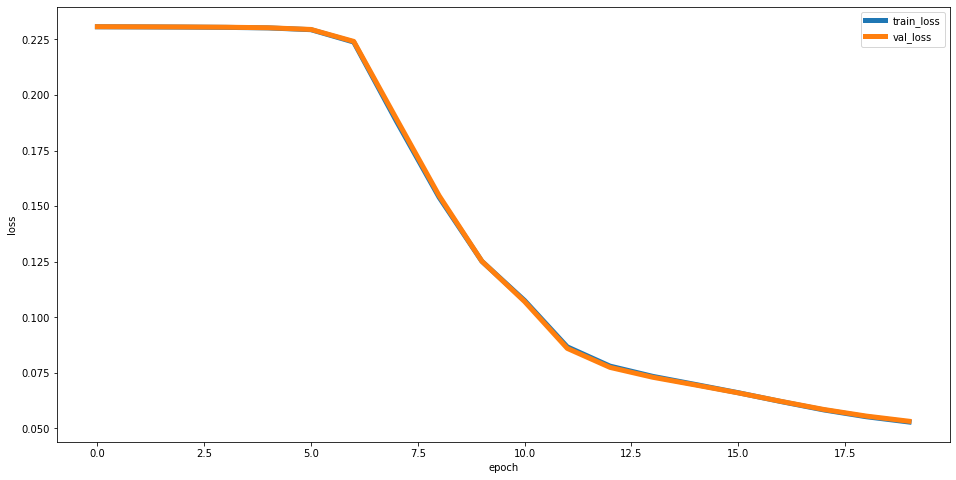

In [21]:
plot_learning_curve(scratch_model_1.train_loss, scratch_model_1.val_loss)

##SGD + HeInitializer + ReLu

In [22]:
class Model2(ScratchDeepNeuralNetrowkClassifier):
    def fit(self, X, y, X_val=None, y_val=None):
        self.sigma      = 0.01
        self.lr         = 0.01
        self.n_features = X.shape[1] # number of features
        self.n_nodes1   = 400
        self.n_nodes2   = 200
        self.n_output   = y.shape[1] # number of output classes (number of nodes in the 3rd layer)

        self.train_loss = []
        self.val_loss = []

        # Initialize
        optimizer = SGD(self.lr)
        self.FC1 = FC(self.n_features, self.n_nodes1, HeInitializer(self.sigma), optimizer)
        self.activation1 = ReLu()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, HeInitializer(self.sigma), optimizer)
        self.activation2 = ReLu()
        self.FC3 = FC(self.n_nodes2, self.n_output, HeInitializer(self.sigma), optimizer)
        self.activation3 = Softmax()

        for i in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            for index, (X_batch, y_batch) in enumerate(get_mini_batch):
                # Forward
                Z3 = self._feed_forward(X_batch)

                # Backprop
                self._backpropagation(Z3, y_batch)

            self.train_loss.append(self._loss_function(self.predict_proba(X), y))
            if X_val is not None and y_val is not None:
                self.val_loss.append(self._loss_function(self.predict_proba(X_val), y_val))

            if self.verbose:
                print(f'epoch: {i}, loss: {self.train_loss[-1]}')

In [23]:
scratch_model_2 = Model2()
scratch_model_2.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

epoch: 0, loss: 0.23009952560896024
epoch: 1, loss: 0.23009969434985472
epoch: 2, loss: 0.23009983309661047
epoch: 3, loss: 0.23009979640330103
epoch: 4, loss: 0.23009970261378132
epoch: 5, loss: 0.2300995229122855
epoch: 6, loss: 0.2300991162650912
epoch: 7, loss: 0.23009786981125113
epoch: 8, loss: 0.23009141129017174
epoch: 9, loss: 0.22995951225716021
epoch: 10, loss: 0.1729871589817959
epoch: 11, loss: 0.1439175016061887
epoch: 12, loss: 0.12897785915317098
epoch: 13, loss: 0.1139199083861546
epoch: 14, loss: 0.0713705310935132
epoch: 15, loss: 0.046045277891091974
epoch: 16, loss: 0.03620918064431919
epoch: 17, loss: 0.029680186769297415
epoch: 18, loss: 0.024936758734442736
epoch: 19, loss: 0.021361713370280765


In [24]:
y_pred = scratch_model_2.predict(X_val)

In [25]:
accuracy_score(y_pred, y_val)

0.93275

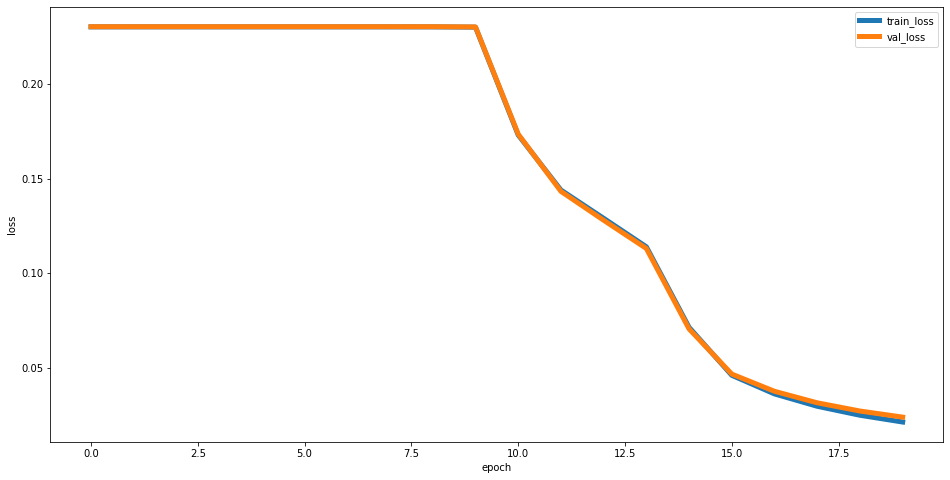

In [26]:
plot_learning_curve(scratch_model_2.train_loss, scratch_model_2.val_loss)

##SGD + XavierInitializer + Tanh

In [27]:
class Model3(ScratchDeepNeuralNetrowkClassifier):
    def fit(self, X, y, X_val=None, y_val=None):
        self.sigma      = 0.01
        self.lr         = 0.01
        self.n_features = X.shape[1] # number of features
        self.n_nodes1   = 400
        self.n_nodes2   = 200
        self.n_output   = y.shape[1] # number of output classes (number of nodes in the 3rd layer)

        self.train_loss = []
        self.val_loss = []

        # Initialize
        optimizer = SGD(self.lr)
        self.FC1 = FC(self.n_features, self.n_nodes1, XavierInitializer(self.sigma), optimizer)
        self.activation1 = Tanh()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, XavierInitializer(self.sigma), optimizer)
        self.activation2 = Tanh()
        self.FC3 = FC(self.n_nodes2, self.n_output, XavierInitializer(self.sigma), optimizer)
        self.activation3 = Softmax()

        for i in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            for index, (X_batch, y_batch) in enumerate(get_mini_batch):
                # Forward
                Z3 = self._feed_forward(X_batch)

                # Backprop
                self._backpropagation(Z3, y_batch)

            self.train_loss.append(self._loss_function(self.predict_proba(X), y))
            if X_val is not None and y_val is not None:
                self.val_loss.append(self._loss_function(self.predict_proba(X_val), y_val))

            if self.verbose:
                print(f'epoch: {i}, loss: {self.train_loss[-1]}')

In [28]:
scratch_model_3 = Model3()
scratch_model_3.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

epoch: 0, loss: 0.23009950458946427
epoch: 1, loss: 0.23009968329169303
epoch: 2, loss: 0.2300998200981513
epoch: 3, loss: 0.23009978127069775
epoch: 4, loss: 0.23009968726799382
epoch: 5, loss: 0.23009951436221263
epoch: 6, loss: 0.23009914402244247
epoch: 7, loss: 0.23009809396855568
epoch: 8, loss: 0.23009291914003735
epoch: 9, loss: 0.22995393843542075
epoch: 10, loss: 0.17267959049746212
epoch: 11, loss: 0.1585085790497863
epoch: 12, loss: 0.11324104018275258
epoch: 13, loss: 0.0784079497547718
epoch: 14, loss: 0.054060297236540024
epoch: 15, loss: 0.041190518387478996
epoch: 16, loss: 0.035288632222752976
epoch: 17, loss: 0.031675001310700696
epoch: 18, loss: 0.02930739464969594
epoch: 19, loss: 0.027334245648001496


In [29]:
y_pred = scratch_model_3.predict(X_val)

In [30]:
accuracy_score(y_pred, y_val)

0.9171666666666667

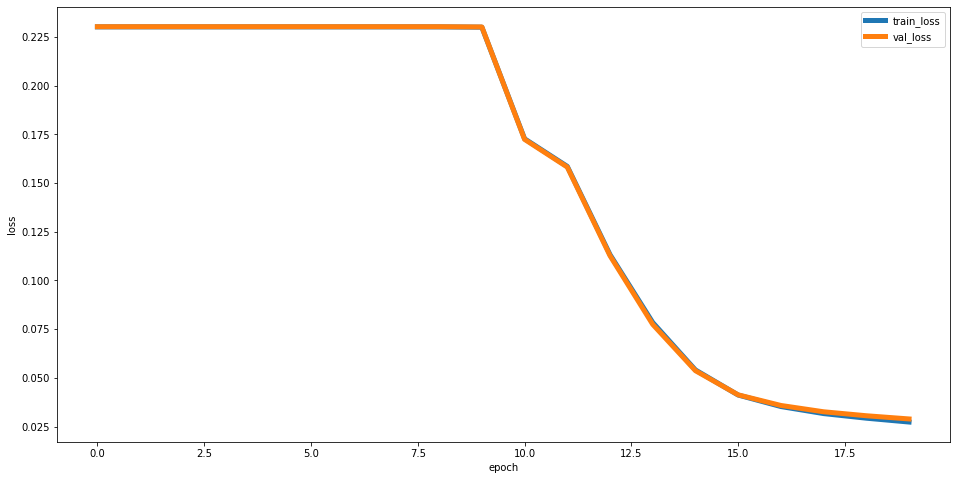

In [31]:
plot_learning_curve(scratch_model_3.train_loss, scratch_model_3.val_loss)

##AdaGrad

In [32]:
class Model4(ScratchDeepNeuralNetrowkClassifier):
    def fit(self, X, y, X_val=None, y_val=None):
        self.sigma      = 0.01
        self.lr         = 0.01
        self.n_features = X.shape[1] # number of features
        self.n_nodes1   = 400
        self.n_nodes2   = 200
        self.n_output   = y.shape[1] # number of output classes (number of nodes in the 3rd layer)

        self.train_loss = []
        self.val_loss = []

        # Initialize
        optimizer = AdaGrad(self.lr)
        self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
        self.activation1 = ReLu()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        self.activation2 = ReLu()
        self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
        self.activation3 = Softmax()

        for i in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            for index, (X_batch, y_batch) in enumerate(get_mini_batch):
                # Forward
                Z3 = self._feed_forward(X_batch)

                # Backprop
                self._backpropagation(Z3, y_batch)

            self.train_loss.append(self._loss_function(self.predict_proba(X), y))
            if X_val is not None and y_val is not None:
                self.val_loss.append(self._loss_function(self.predict_proba(X_val), y_val))

            if self.verbose:
                print(f'epoch: {i}, loss: {self.train_loss[-1]}')

In [33]:
scratch_model_4 = Model4()
scratch_model_4.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

epoch: 0, loss: 0.08010771493611227
epoch: 1, loss: 0.043002561903171685
epoch: 2, loss: 0.034281276711159665
epoch: 3, loss: 0.02912809957450224
epoch: 4, loss: 0.025008908682984148
epoch: 5, loss: 0.021541167032771594
epoch: 6, loss: 0.018687408366915258
epoch: 7, loss: 0.01634013483353358
epoch: 8, loss: 0.014406595793425913
epoch: 9, loss: 0.012819488836848457
epoch: 10, loss: 0.011502715168985572
epoch: 11, loss: 0.010362671794986539
epoch: 12, loss: 0.009392026806531539
epoch: 13, loss: 0.008558102876788815
epoch: 14, loss: 0.007836891334179091
epoch: 15, loss: 0.007205431766857207
epoch: 16, loss: 0.00664013354360524
epoch: 17, loss: 0.00612729711019954
epoch: 18, loss: 0.005646967857585243
epoch: 19, loss: 0.005220060416501482


In [34]:
y_pred = scratch_model_4.predict(X_val)

In [35]:
accuracy_score(y_pred, y_val)

0.97025

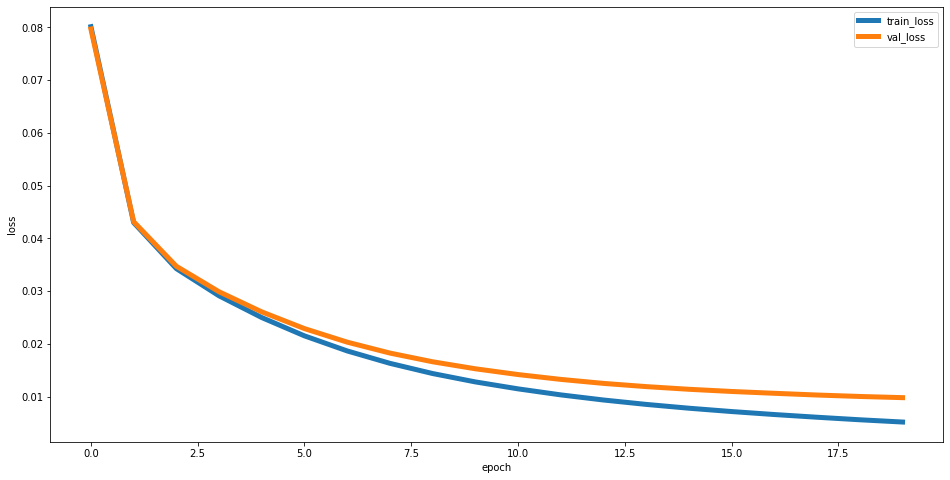

In [36]:
plot_learning_curve(scratch_model_4.train_loss, scratch_model_4.val_loss)